In [1]:
import numpy as np 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#from scipy.interpolate import Akima1DInterpolator
#from scipy.stats import multivariate_normal
import time 
#import corner
#import h5py
#import ipdb
from scipy import integrate 
from tqdm import tqdm
#import os
import pandas as pd
import camb 
from camb import model, initialpower
from CosmologyCalculatorPC import CosmologyCalculatorPC

# Generate $d_L(z)$ using CAMB for $\Lambda CDM$

**Load camb with H0=73, $\mathbf{\Omega_m = 0.24}$ -- same as what I used to produce the PCs**

In [2]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Generate $d_L(z)$ using my PCs

In [3]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.

Nx = 500
zzmin = 0.03
zzmax = 1.7
zBinsFisher = np.array([zzmin + i * (zzmax - zzmin) / Nx for i in range(1, Nx + 1)])
zbins = np.insert(zBinsFisher, 0, 0.03)

alphasfid = np.array([0] * 500) # When all amplitudes are zero, I get back ΛCDM

eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2_500PCs_0p03_to_1p7.dat")
#eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2.dat")

eigenvectors.shape

(500, 500)

In [4]:
calculator = CosmologyCalculatorPC(73,0.24, 0, alphasfid, eigenvectors)

In [5]:
cambhub = [results.hubble_parameter(z) for z in zBinsFisher]
camblum = [results.luminosity_distance(z) for z in zBinsFisher]

- **Check that $\mathbf{H(z)}$ works as expected**

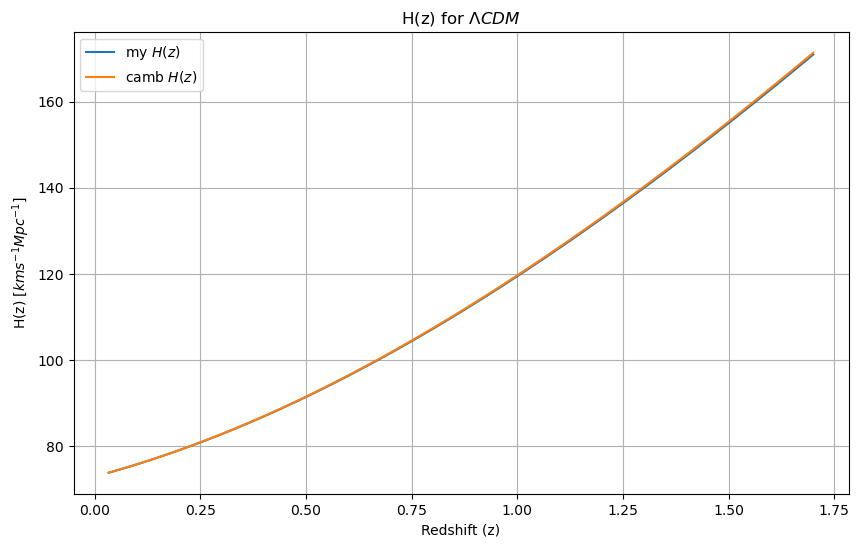

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator.hubble(zbins, zBinsFisher) , label=r'my $H(z)$')
plt.plot(zBinsFisher, cambhub, label=r'camb $H(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'H(z) $[km s^{-1} Mpc^{-1}]$')
plt.title(r'H(z) for $\Lambda CDM$')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

- **Check that $\mathbf{d_L(z)}$ agrees with $\mathbf{\Lambda CDM}$ from CAMB**

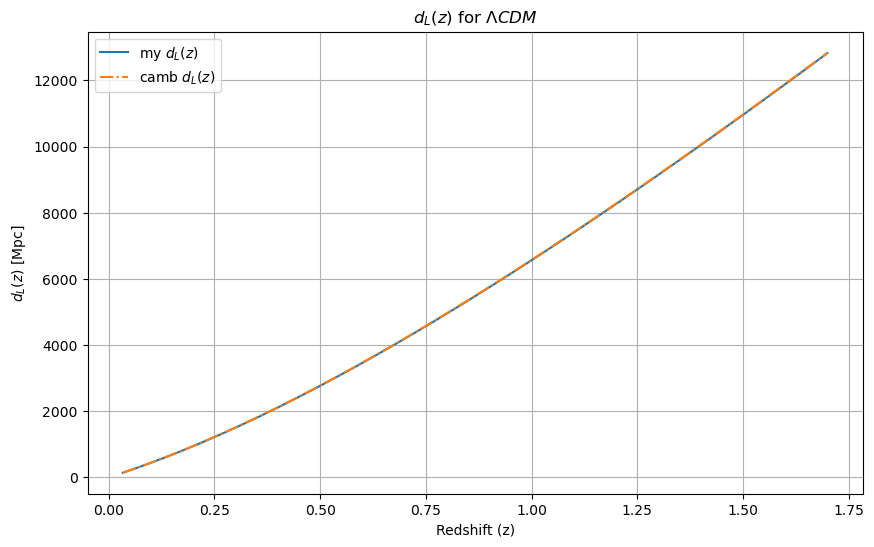

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
plt.plot(zBinsFisher, camblum, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
plt.legend()
plt.grid(True)
plt.show()

# Completness Tests

- First we need to project the dynamic DE model on the PCs that we have. For the purposes of this calculation, we will assume a specific form for our DE EoS, namely
  
  $ w(z) = w_0 + w_a (1 - a) \Rightarrow w(z) = w_0 + w_a ( \frac{z}{1+z})$ with $w_0=-0.827 \pm 0.063$ and $w_a = -0.75^{+0.29}_{-0.25}$ 
  
  (ref: https://data.desi.lbl.gov/public/papers/y1/DESI2024_VI_BAO_COSMOLOGY.pdf eq 5.6).

In [8]:
def dyn_w(z, w0, wa):
    return w0 + wa *( z / (1 + z))
dyn_w_list = [dyn_w(z, -0.827, -0.75) for z in zBinsFisher]
dyn_w_array = np.array(dyn_w_list)

In [9]:
alphasQ = []
for i in range(500):
    a =  np.sum((dyn_w_array + 1) * eigenvectors[i][:])
    alphasQ.append(a)
alphasQ = np.array(alphasQ)

- In the plot below we are comparing the reconstruction of the EoS using all 500 PCs compared to the analytical expression.

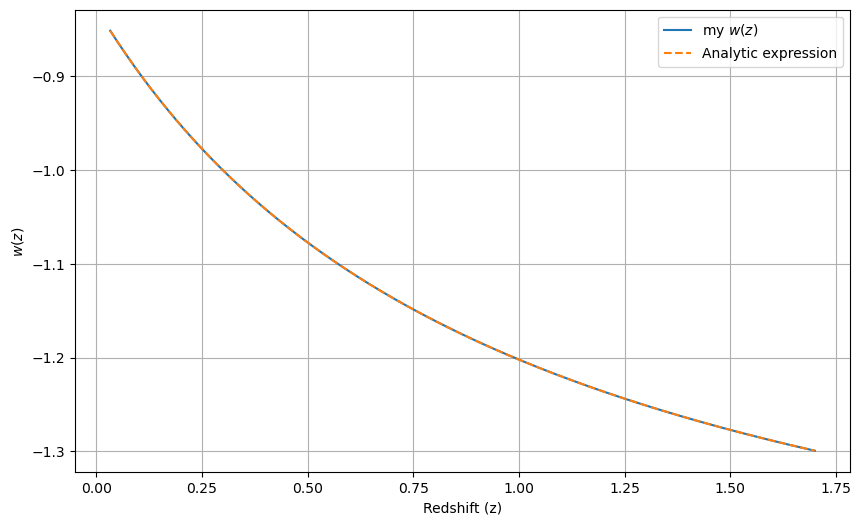

In [10]:
calculator500 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ, eigenvectors)
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator500.w(), label=r'my $w(z)$')
plt.plot(zBinsFisher, dyn_w_list, linestyle='--', label=r'Analytic expression')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$w(z)$ ')
plt.legend()
plt.grid(True)
plt.show()

#### Define comparison method and plot it for different choices of PCs

Define a comparing criterion between my PC functions and the camb answer

In [11]:
def criterion(f_pc, f_exp, sigma_sq):
    ''' All the inputs are numpy arrays '''
    return (f_exp - f_pc ) ** 2 / sigma_sq

##### \% fractional for $w(z)

In [12]:
def frac_dif(w_pc, w_exp):
    return ((w_pc - w_exp)/ (w_exp)) * 100
    

- Define the $\sigma$ as shown in equation A2 from 0810.1744

- Note that using the uncertainty calculated in the cell below along with the criterion as define in the previous cell, we basically end up getting equation A6 from 0810.1744, when I use it for the log of $d_L$ 

In [13]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0 ]
zSN = [0.03, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75 ]

dz1 = 0.1
dz2 = 0.07
tmp = zBinsFisher[1] - zBinsFisher[0]
fnSN = np.interp(zBinsFisher, zSN, NSN)
sigma2SNfisher = []

for i, z in enumerate(zBinsFisher):
    if z < 0.1:
        dz = dz2
    else:
        dz = dz1
    
    sigma2SNfisher.append(
        dz / tmp * (0.15**2 / fnSN[i] + 0.02**2 * ((1 + z) / 2.7)**2)
    )

sigma2SNfisher = np.array(sigma2SNfisher)

In [14]:
calculator500 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ, eigenvectors)
calculator1 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:1], eigenvectors[:1])
calculator5 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:5], eigenvectors[:5])
calculator10 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:10], eigenvectors[:10])
calculator50 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:50], eigenvectors[:50])
calculator100 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:100], eigenvectors[:100])
calculator150 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:150], eigenvectors[:150])
calculator30 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:30], eigenvectors[:30])
calculator20 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:20], eigenvectors[:20])
calculator15 = CosmologyCalculatorPC(73, 0.24, 0, alphasQ[:15], eigenvectors[:15])



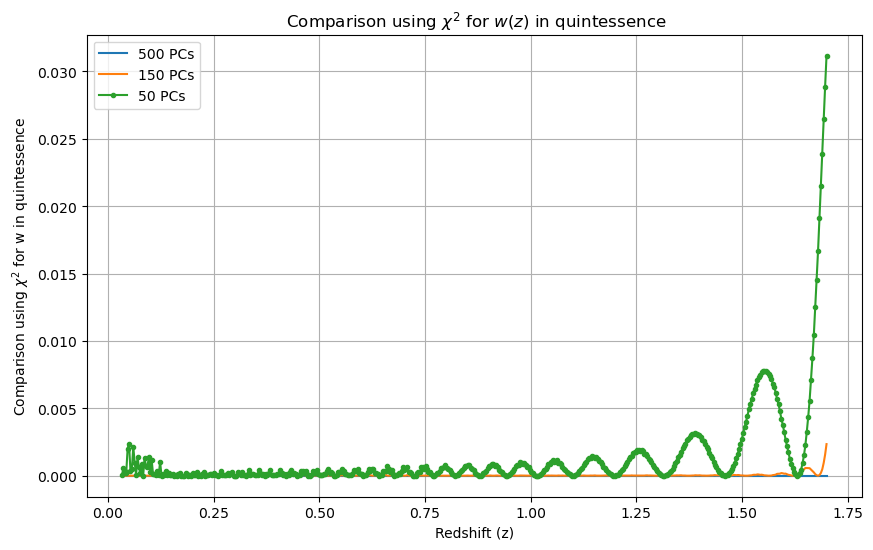

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(calculator500.w(), dyn_w_array, sigma2SNfisher) , label=r'500 PCs')
plt.plot(zBinsFisher, criterion(calculator150.w(), dyn_w_array, sigma2SNfisher) , label=r'150 PCs')
plt.plot(zBinsFisher, criterion(calculator50.w(), dyn_w_array, sigma2SNfisher) ,marker = '.', label=r'50 PCs')



#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'Comparison using $\chi^2$ for w in quintessence')
plt.title(r' Comparison using $\chi^2$ for $w(z)$ in quintessence')
plt.legend()
plt.grid(True)
plt.show()

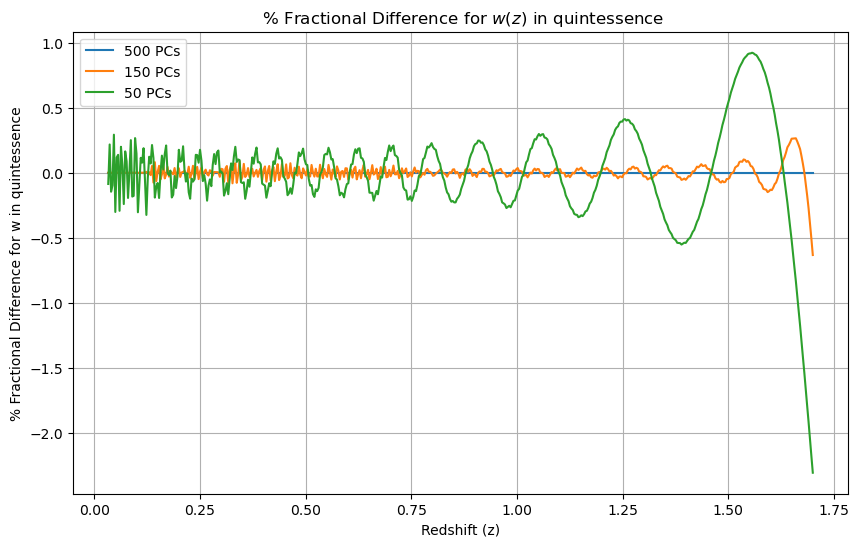

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, frac_dif(calculator500.w(), dyn_w_array) ,  label=r'500 PCs')
plt.plot(zBinsFisher, frac_dif(calculator150.w(), dyn_w_array) , label=r'150 PCs')
plt.plot(zBinsFisher, frac_dif(calculator50.w(), dyn_w_array) , label=r'50 PCs')
# plt.plot(zBinsFisher, calculator10.lum_distance(zbins, zBinsFisher) , label=r'10 PCs')
# plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'50 PCs')
# plt.plot(zBinsFisher, calculator100.lum_distance(zbins, zBinsFisher) , label=r'100 PCs')
# plt.plot(zBinsFisher, calculator150.lum_distance(zbins, zBinsFisher) , label=r'150 PCs')


#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'% Fractional Difference for w in quintessence')
plt.title(r' % Fractional Difference for $w(z)$ in quintessence')
plt.legend()
plt.grid(True)
plt.show()

- As expected when we reduce the number of PCs that we use, the $\chi^2$ for the EoS $w(z)$ gets modified significantly. We will now check what happens for the luminosity distance -- for which we expect results won't be as dramatic.

#### $\chi^2$ for $d_L(z)$

- I need to setup camb with the changed DE EoS so that I can compare my results with it.

In [19]:
from camb.dark_energy import DarkEnergyPPF
pars = camb.CAMBparams()
pars.set_cosmology(H0=73, ombh2=0.0255792, omch2=0.1023168, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.956, r=0)

pars.DarkEnergy = DarkEnergyPPF(w=-0.827, wa=-0.75)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [20]:
dyn_w_dl_array = [results.luminosity_distance(z) for z in zBinsFisher]

## Define the logarithm of the luminosity distance to use later

cmag = 149896229 / 500  # Speed of light in km/s/Mpc
logH0_dl_array = np.log10( (73 / cmag) * np.array(dyn_w_dl_array))

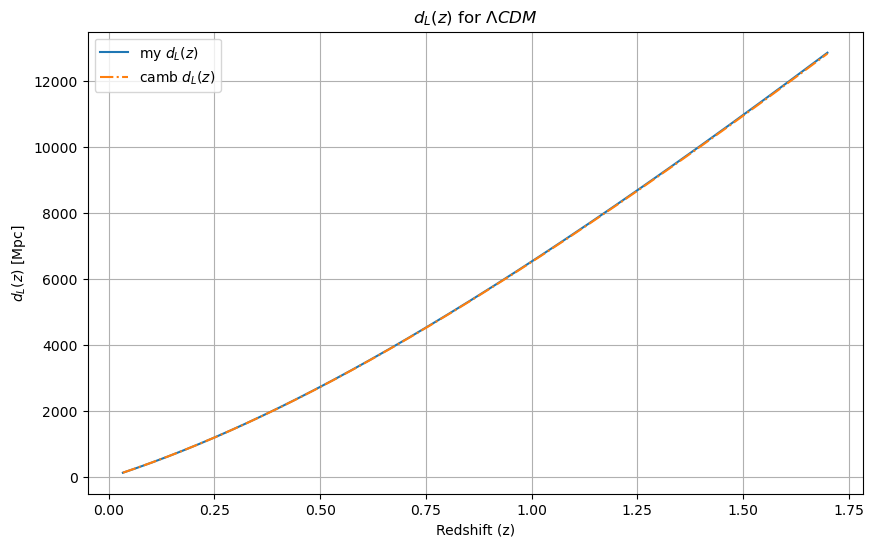

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, calculator500.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$')
#plt.plot(zBinsFisher, calculator50.lum_distance(zbins, zBinsFisher) , label=r'my $d_L(z)$, 50 PCs')
plt.plot(zBinsFisher, dyn_w_dl_array, linestyle='-.', label=r'camb $d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$d_L(z)$ [Mpc]')
plt.title(r'$d_L(z)$ for $\Lambda CDM$')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

- It seems that with 50 PCs I do exceptionally well in terms of the $\chi^2$.
- With 20 PCs, I am still close but visibly different than 500 PCs, especially for the larger values of z. This behavior in the high z values is expected because I have ignored a lot of high PCs.

- In order to compare and figure out how many PCs I need for the completeness of my basis, I need to compare the average magnitudes I get from my PC reconstruction vs the CAMB output. 

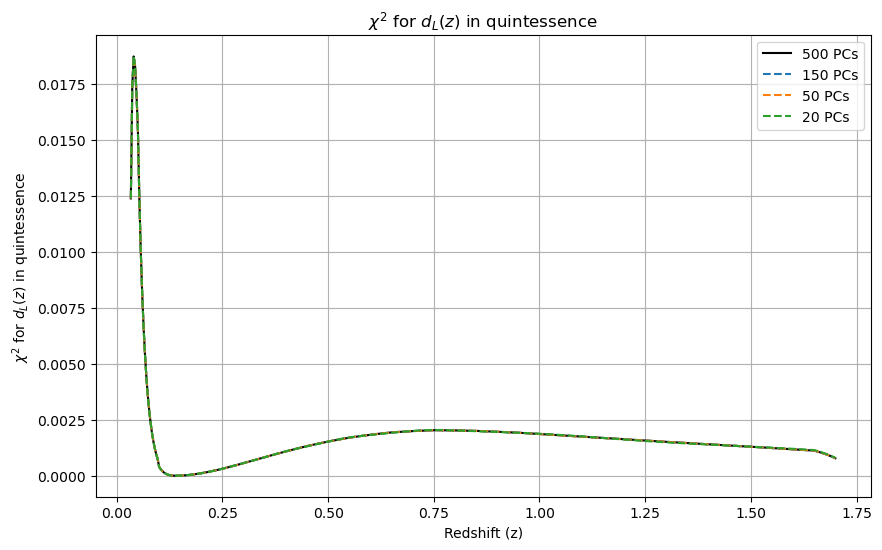

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(zBinsFisher, criterion(5*calculator500.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array , sigma2SNfisher), color='black', label=r'500 PCs')
plt.plot(zBinsFisher, criterion(5*calculator150.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array, sigma2SNfisher) , linestyle='--', label=r'150 PCs')

plt.plot(zBinsFisher, criterion(5*calculator50.logH0lum_distance(zbins, zBinsFisher) , 5*logH0_dl_array, sigma2SNfisher),linestyle='--', label=r'50 PCs')

plt.plot(zBinsFisher, criterion(5*calculator20.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array, sigma2SNfisher ), linestyle='--', label=r'20 PCs')

#plt.plot(zBinsFisher, criterion(5*calculator10.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array, sigma2SNfisher ), linestyle=':', color='C0',label=r'10 PCs')



#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\chi^2$ for $d_L(z)$ in quintessence')
plt.title(r'$\chi^2$ for $d_L(z)$ in quintessence')
# plt.xlim(1.5, 1.7)
# plt.ylim(0.0010,0.0014)
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# plt.figure(figsize=(10, 6))
# plt.plot(zBinsFisher, frac_dif(5*calculator500.logH0lum_distance(zbins, zBinsFisher), 5*logH0_dl_array), color='black', label=r'500 PCs')
# plt.plot(zBinsFisher, frac_dif(5*calculator50.logH0lum_distance(zbins, zBinsFisher) , 5*logH0_dl_array),linestyle='--', label=r'50 PCs')
# plt.plot(zBinsFisher, frac_dif(5*calculator20.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array ), linestyle='--', label=r'20 PCs')
# plt.plot(zBinsFisher, frac_dif(5*calculator10.logH0lum_distance(zbins, zBinsFisher) ,5*logH0_dl_array ), linestyle=':', color='C0',label=r'10 PCs')



# #plt.yscale('log')
# plt.xlabel('Redshift (z)')
# plt.ylabel(r'\% fractional difference for $d_L(z)$ in quintessence')
# plt.title(r'\% fractional difference for $d_L(z)$ in quintessence')
# # plt.xlim(1.5, 1.7)
# # plt.ylim(0.2,0.25)
# plt.legend()
# plt.grid(True)
# plt.show()